In [46]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# PINN 모델 정의
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 50), nn.ReLU(),
            nn.Linear(50, 50), nn.ReLU(),
            nn.Linear(50, 50), nn.ReLU(),
            nn.Linear(50, 50), nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x, y, t):
        input_data = torch.stack([x.view(-1), y.view(-1), t.view(-1)], dim=1)
        return self.model(input_data)

# 초기 조건 (물리적 단위에 맞게 수정)
def initial_condition(x, y):
    u_initial = np.sin(2 * np.pi * x)  # 초기 속도 u (예: 사인 함수)
    v_initial = np.zeros_like(y)  # 초기 속도 v (예: 0)
    p_initial = np.zeros_like(x)  # 초기 압력 p (예: 0)

    return u_initial, v_initial, p_initial

# 경계 조건 (물리적 단위에 맞게 수정)
def boundary_conditions(x, y, t):
    u_boundary = np.zeros_like(x)  # 경계에서의 속도 u (예: 0)
    v_boundary = np.zeros_like(y)  # 경계에서의 속도 v (예: 0)
    p_boundary = np.zeros_like(x)  # 경계에서의 압력 p (예: 0)

    return u_boundary, v_boundary, p_boundary

# NS 방정식의 잔차 계산
def navier_stokes_residual(uvp, x, y, t):
    u, v, p = torch.chunk(uvp, 3, dim=1)  # u, v, p로 분할

    # NS 방정식의 잔차 계산 (물리적 단위에 맞게 수정)
    du_dt = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    du_dy = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    
    dv_dt = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    dv_dx = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    dv_dy = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    
    dp_dx = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    dp_dy = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

    residual_u = du_dt + u * du_dx + v * du_dy + dp_dx
    residual_v = dv_dt + u * dv_dx + v * dv_dy + dp_dy
    residual_p = du_dx + dv_dy

    return residual_u, residual_v, residual_p

# 학습 데이터 생성 (물리적 단위에 맞게 수정)
x_initial = np.linspace(0, 1, 100).reshape(-1, 1)
y_initial = np.linspace(0, 1, 100).reshape(-1, 1)
t_initial = np.zeros_like(x_initial)
x_boundary = np.linspace(0, 1, 100).reshape(-1, 1)
y_boundary = np.linspace(0, 1, 100).reshape(-1, 1)
t_boundary = np.linspace(0, 2, 100).reshape(-1, 1)
x_collocation = np.random.uniform(0, 1, size=(100, 1))
y_collocation = np.random.uniform(0, 1, size=(100, 1))
t_collocation = np.linspace(0, 1, 50).reshape(-1, 1)

# 모델 생성 및 학습 (2D 선형 이동 방정식)
model = PINN().cuda()

def train_PINN(model, x_initial, y_initial, t_initial, x_boundary, y_boundary, t_boundary, x_collocation, y_collocation, t_collocation, epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        optimizer.zero_grad() 

        x_initial_grid, y_initial_grid = np.meshgrid(x_initial, y_initial)
        t_initial_grid = np.full_like(x_initial_grid, t_initial)

        x_initial_tensor, y_initial_tensor, t_initial_tensor, x_boundary_tensor, y_boundary_tensor, t_boundary_tensor = (
            torch.tensor(x, dtype=torch.float32, device="cuda", requires_grad=True) for x in
            [x_initial_grid, y_initial_grid, t_initial_grid, x_boundary, y_boundary, t_boundary]
        )


        u_initial_pred, u_boundary_pred1, u_boundary_pred2, u_boundary_pred3, u_boundary_pred4 = (
            model(x, y, t) for x, y, t in
            [(x_initial_tensor, y_initial_tensor, t_initial_tensor), 
            (x_boundary_tensor, torch.zeros_like(y_boundary_tensor), t_boundary_tensor), 
            (torch.ones_like(x_boundary_tensor), y_boundary_tensor, t_boundary_tensor),
            (x_boundary_tensor, torch.ones_like(y_boundary_tensor), t_boundary_tensor),
            (torch.zeros_like(x_boundary_tensor), y_boundary_tensor, t_boundary_tensor)]
        )

        
        u_initial_exact, u_boundary_exact1, u_boundary_exact2, u_boundary_exact3, u_boundary_exact4 = (
            torch.tensor(u, device = "cuda",dtype=torch.float32) for u in [initial_condition(x_initial_grid, y_initial_grid), 
            boundary_conditions(x_boundary, np.zeros_like(y_boundary), t_boundary),
            boundary_conditions(np.ones_like(x_boundary), y_boundary, t_boundary),
            boundary_conditions(x_boundary, np.ones_like(y_boundary), t_boundary),
            boundary_conditions(np.zeros_like(x_boundary), y_boundary, t_boundary)]
        )
        
        loss1 = loss_fn(u_initial_pred.view(-1,1), u_initial_exact.view(-1,1))  # u 초기 조건의 잔차
        loss2 = loss_fn(u_boundary_pred1.view(-1,1), u_boundary_exact1.view(-1,1))  # 경계 조건 1의 잔차
        loss3 = loss_fn(u_boundary_pred2.view(-1,1), u_boundary_exact2.view(-1,1))  # 경계 조건 2의 잔차
        loss4 = loss_fn(u_boundary_pred3.view(-1,1), u_boundary_exact3.view(-1,1))  # 경계 조건 3의 잔차
        loss5 = loss_fn(u_boundary_pred4.view(-1,1), u_boundary_exact4.view(-1,1))  # 경계 조건 4의 잔차

        
        loss6 = 0
        for t_collocation_batch_ in t_collocation:
            idx = np.random.choice(len(x_collocation), size=50, replace=False)
            x_collocation_batch = x_collocation[idx]
            y_collocation_batch = y_collocation[idx]
            t_collocation_batch = np.full(x_collocation_batch.shape, t_collocation_batch_)

            x_collocation_tensor, y_collocation_tensor, t_collocation_tensor = (
                torch.tensor(x_collocation_batch, dtype=torch.float32, device = "cuda", requires_grad=True) for x_collocation_batch in
                [x_collocation_batch, y_collocation_batch, t_collocation_batch]
            )

            u_collocation_pred = model(x_collocation_tensor, y_collocation_tensor, t_collocation_tensor)
            equation_residual_u, equation_residual_v, equation_residual_p = navier_stokes_residual(u_collocation_pred, x_collocation_tensor, y_collocation_tensor, t_collocation_tensor)

            loss6 += loss_fn(equation_residual_u, torch.zeros_like(equation_residual_u)) + \
                    loss_fn(equation_residual_v, torch.zeros_like(equation_residual_v)) + \
                    loss_fn(equation_residual_p, torch.zeros_like(equation_residual_p))

        loss = loss1 + loss2 + loss3 + loss4 + loss5 + loss6
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(loss1.item(), loss2.item(), loss3.item(), loss4.item(), loss5.item(), loss6.item())
            print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item()}")

    print("Training completed.")

# 모델 학습
train_PINN(model, x_initial, y_initial, t_initial, x_boundary, y_boundary, t_boundary, x_collocation, y_collocation, t_collocation, epochs=500, learning_rate=0.01)


0.16634628176689148 0.0013483441434800625 0.0014983706641942263 0.0014029619051143527 0.0013090966967865825 0.030687490478157997
Epoch [0/500], Loss: 0.20259255170822144
0.16473878920078278 3.660608399513876e-06 1.391878686263226e-05 2.9702136998821516e-06 5.378043624659767e-06 0.00013927182590123266
Epoch [100/500], Loss: 0.16490398347377777


KeyboardInterrupt: 

Text(0.5, 1.0, 'p(x, y) at t=0 sec (Predicted)')

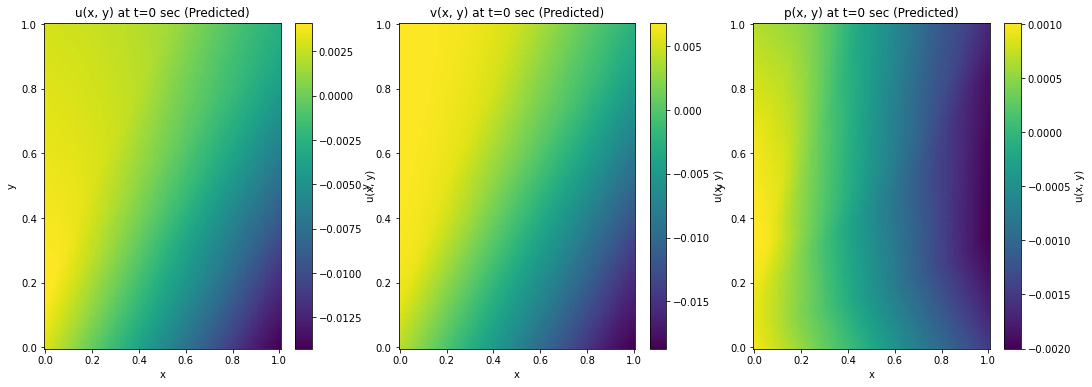

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# 초기 상태에서의 그래프 그리기
x_grid = np.linspace(0, 1, 100)
y_grid = np.linspace(0, 1, 100)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)


# t=0초와 t=2초에서의 u(x, y) 계산
t_0 = 0
t_0 = np.array([t_0 for i in range(len(x_grid)*len(y_grid))])

# 모델을 사용하여 예측
q_0_pred = model(torch.tensor(x_mesh, device = "cuda", dtype=torch.float32).view(-1, 1),
            torch.tensor(y_mesh, device = "cuda", dtype=torch.float32).view(-1, 1),
            torch.tensor(t_0, device = "cuda", dtype=torch.float32).view(-1, 1)).cpu().detach().numpy()


# 2D 그래프 그리기
plt.figure(figsize=(18, 6))

# t=0초에서의 그래프 비교
plt.subplot(131)
plt.pcolormesh(x_grid, y_grid, q_0_pred[:,0].reshape(-1,1).reshape(100,100), cmap='viridis')
plt.colorbar(label='u(x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('u(x, y) at t=0 sec (Predicted)')

# t=0초에서의 그래프 비교
plt.subplot(132)
plt.pcolormesh(x_grid, y_grid, q_0_pred[:,1].reshape(-1,1).reshape(100,100), cmap='viridis')
plt.colorbar(label='u(x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('v(x, y) at t=0 sec (Predicted)')


# t=0초에서의 그래프 비교
plt.subplot(133)
plt.pcolormesh(x_grid, y_grid, q_0_pred[:,2].reshape(-1,1).reshape(100,100), cmap='viridis')
plt.colorbar(label='u(x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('p(x, y) at t=0 sec (Predicted)')

